# UC Berkeley gender bias (Simpson's paradox)

The study of gender bias among graduate school admissions to UC Berkeley (fall of 1973) is one of the most well-known examples of Simpson's paradox. 

In [1]:
%matplotlib inline
import pandas as pd

# to make plots a bit fancier
import seaborn
%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

In [2]:
flat_df = pd.read_csv('berkeley_case.csv', sep = ';')

In [ ]:
flat_df = pd.read_csv('berkeley_case.csv', sep = ';')

In [16]:
flat_df.head()

,faculty,gender,param,number
0,A,men,applied,825
1,A,men,accepted,512
2,A,women,applied,108
3,A,women,accepted,89
4,B,men,applied,560


In [3]:
def round_2digits(x):
    return round(x, 2)

In [21]:
total_stats = pd.pivot_table(flat_df, aggfunc = sum, index = 'gender', columns = 'param', values = 'number')
total_stats 

param,accepted,applied
gender,,
men,1192,2590
women,557,1835


In [28]:
total_stats['perc_admitted'] = map(round_2digits, 100*total_stats.accepted/total_stats.applied)

In [29]:
total_stats

param,accepted,applied,perc_admitted
gender,,,
men,1192,2590,<map object at 0x0000009FCD69CDC8>
women,557,1835,<map object at 0x0000009FCD69CDC8>


The admission figures showed that men applying were more likely than women to be admitted, and the difference was so large that it was unlikely to be due to chance. But let's investigate question a little big deeper and see percentage of admitted students by gender on different faculties. 

Pandas MultiIndex will be rather handy for this task. The most common way to create a DataFrame with multi-index is to make it with pivot_table.

In [5]:
df = pd.pivot_table(flat_df, index = 'faculty', values = 'number', columns = ['gender', 'param'])
df

gender       men            women        
param   accepted applied accepted applied
faculty                                  
A            512     825       89     108
B            353     560       17      25
C            120     325      202     593
D            138     417      131     375
E             53     191       94     393
F             16     272       24     341

In [6]:
# we can filter on level = 0 like this
df['women']

param,accepted,applied
faculty,,
A,89,108
B,17,25
C,202,593
D,131,375
E,94,393
F,24,341


In [7]:
# to filter on subsequent levels we could use slicers
idx = pd.IndexSlice
df.loc[idx[:], idx[:, 'accepted']]

gender,men,women
param,accepted,accepted
faculty,,
A,512,89
B,353,17
C,120,202
D,138,131
E,53,94
F,16,24


In [8]:
# to access particular column 
df['women', 'applied']

faculty
A    108
B     25
C    593
D    375
E    393
F    341
Name: (women, applied), dtype: int64

Also let's calculate the total statistics (for men and women together) and concatenate it to initial df

In [9]:
df_total = (df['men'] + df['women']).T
df_total.T

param,accepted,applied
faculty,,
A,601,933
B,370,585
C,322,918
D,269,792
E,147,584
F,40,613


In [10]:
df_total['gender'] = 'total'
df_total.set_index('gender', append = True, inplace = True)
df_total = df_total.reorder_levels(['gender', 'param']).T
df_total

gender     total        
param   accepted applied
faculty                 
A            601     933
B            370     585
C            322     918
D            269     792
E            147     584
F             40     613

In [11]:
df = pd.concat([df, df_total], axis = 1)
df

gender       men            women            total        
param   accepted applied accepted applied accepted applied
faculty                                                   
A            512     825       89     108      601     933
B            353     560       17      25      370     585
C            120     325      202     593      322     918
D            138     417      131     375      269     792
E             53     191       94     393      147     584
F             16     272       24     341       40     613

Now let's move to calculating admission rates by faculties and adding this info to initial table

In [12]:
df_inv = df.reorder_levels(['param', 'gender'], axis = 1).sort_index(level = 0, axis = 1)
admitted_perc = (100*df_inv.accepted/df_inv.applied).applymap(round_2digits)
admitted_perc

gender,men,total,women
faculty,,,
A,62.06,64.42,82.41
B,63.04,63.25,68.00
C,36.92,35.08,34.06
D,33.09,33.96,34.93
E,27.75,25.17,23.92
F,5.88,6.53,7.04


<AxesSubplot:title={'center':'Percentage of admitted to UC Berkeley'}, xlabel='faculty'>

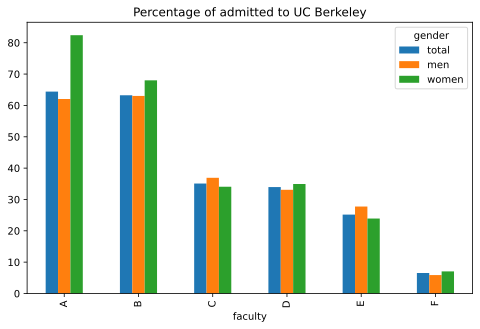

In [13]:
admitted_perc[['total', 'men', 'women']].plot(kind = 'bar', title = 'Percentage of admitted to UC Berkeley')

We saw that on most faculties women are more likely to be admitted, on faculties C and E women's admission rate is a bit smaller than men's (but difference is small and it can be just by chance). So it's a bit confusing: on total values we saw the big difference between women's and men's admission, but the situation is opposite when we are looking at admission rates by faculty (that's Simpson's paradox).
 
The cause it that women tended to apply to competitive departments with low rates of admission even among qualified applicants (such as in the English Department), whereas men tended to apply to less-competitive departments with high rates of admission among the qualified applicants (such as in engineering and chemistry). 
Let's investigate it.

First of all, let's calculate average admission rates for faculties

Then let's calculate the number of aplications by faculties for different genders. 

In [14]:
gender_faculty_applications = pd.pivot_table(flat_df[flat_df.param == 'applied'], 
                                             index = 'faculty', values = 'number', columns = 'gender')
gender_faculty_applications = gender_faculty_applications.apply(lambda x: 100*x/gender_faculty_applications.sum(), axis = 1)
gender_faculty_applications.columns += '_faculty_share'
gender_faculty_applications = gender_faculty_applications.applymap(round_2digits)
gender_faculty_applications

gender,men_faculty_share,women_faculty_share
faculty,,
A,31.85,5.89
B,21.62,1.36
C,12.55,32.32
D,16.10,20.44
E,7.37,21.42
F,10.50,18.58


<AxesSubplot:title={'center':'Statistics on UC Berkeley faculties'}, xlabel='faculty'>

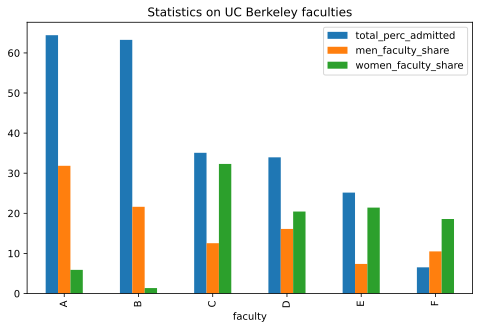

In [15]:
faculty_stats = admitted_perc[['total']].join(gender_faculty_applications)
faculty_stats.columns = ['total_perc_admitted', 'men_faculty_share', 'women_faculty_share']
faculty_stats.plot(kind = 'bar', title = 'Statistics on UC Berkeley faculties')